In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm



files = Path("agg_data").glob("ParlaMint-*.speeches.jsonl")
files = list(files)
dfs = []


for file in tqdm(files):
  if any([i in str(file) for i in ["ES-CT", "ES-GA", "ES-PV"]]):
    continue
  df = pd.read_json(file,
                    lines=True,
                    # nrows=10000,
                    )
  df["country"] = str(file).split("ParlaMint-")[-1].split(".speeches")[0]
  df = pd.concat([df, df.metadata.apply(pd.Series)], axis=1)
  dfs.append(
    df
  )
df = pd.concat(dfs).reset_index(drop=True)
print(df.shape)

100%|██████████| 29/29 [27:35<00:00, 57.09s/it]


(8026469, 29)


In [2]:
countries = ["AT", "BA", "BE", "BG", "CZ", "DK", "EE", "ES-CT", "ES-GA", "ES-PV", "ES", "FI", "FR", "GB", "GR", "HR", "HU", "IS", "IT", "LV", "NL", "NO", "PL", "PT", "RS", "SE", "SI", "TR", "UA", ]

lattitudes = [ 47.33, 44, 50.83, 43, 49.75, 56, 59, 40, 40, 40, 40, 64, 46, 54, 39, 45.17, 47, 65, 42.83, 57, 52.5, 62, 52, 39.5, 44, 62, 46, 39, 49,]
mapper = {k: v for k, v in zip(countries, lattitudes)}

In [3]:
df.head(1)

,newdoc id,logits_pondered,logits_averaged,char_length,metadata,country,Text_ID,ID,Title,Date,...,Speaker_MP,Speaker_minister,Speaker_party,Speaker_party_name,Party_status,Party_orientation,Speaker_ID,Speaker_name,Speaker_gender,Speaker_birth
0,ParlaMint-UA_2022-12-13-m0.u1,3.7954,3.878044,4494,"{'Text_ID': 'ParlaMint-UA-en_2022-12-13-m0', '...",UA,ParlaMint-UA-en_2022-12-13-m0,ParlaMint-UA_2022-12-13-m0.u1,Ukrainian parliamentary corpus ParlaMint-UA-en...,2022-12-13,...,MP,notMinister,-,-,-,-,РусланОлексійовичСтефанчук.1975,"Stefančuk, Ruslan Oleksijovyč",M,1975


In [4]:
# Filtering
# Keep only MPs
c1 = df.Speaker_MP == "MP"

# Exclude non-national parliaments:
c2 = ~df.country.isin(["ES-CT", "ES-GA", "ES-PV", ])

# Exclude chairs:
c3 = df.Speaker_role != "Chairperson"

ndf = df[
    # c1 & \
    c2 & \
    c3
    ]

def map_sentiment_to_category(logit: float) -> str:
    if logit < 2:
        return "Negative"
    elif 2 <= logit < 4:
        return "Neutral"
    else:
        return "Positive"
ndf["sentiment_categorical"] = ndf.logits_pondered.apply(map_sentiment_to_category)


def percentage_of_neutral(l: pd.Series) -> float:
    return (l == "Neutral").sum()/l.shape[0]
def percentage_of_negative(l: pd.Series) -> float:
    return (l == "Negative").sum()/l.shape[0]
def percentage_of_positive(l: pd.Series) -> float:
    return (l == "Positive").sum()/l.shape[0]
def get_female_average_per_country(df: pd.DataFrame, country: str)-> float:
    c1 = df.country == country
    c2 = df.Speaker_gender


gb1 = ndf.groupby("country").agg({
    "logits_pondered": "mean",
    "sentiment_categorical": [percentage_of_positive, percentage_of_neutral, percentage_of_negative]
}).reset_index()
gb1.columns = "country average_sentiment percentage_of_positive percentage_of_neutral percentage_of_negative".split()



gb2 = df.groupby(["country", "Speaker_gender"]).agg({
    "logits_pondered": "mean"
}).reset_index()


gb1["average_female_sentiment"] = gb1.merge(gb2[gb2.Speaker_gender == "F"], on="country", how="outer").logits_pondered
gb1["average_male_sentiment"] = gb1.merge(gb2[gb2.Speaker_gender == "M"], on="country", how="outer").logits_pondered
gb1["male - female"] = gb1.average_male_sentiment - gb1.average_female_sentiment
gb1["lattitude"] = [mapper.get(i) for i in gb1.country]
gb1

/tmp/ipykernel_2514772/969940974.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ndf["sentiment_categorical"] = ndf.logits_pondered.apply(map_sentiment_to_category)


,country,average_sentiment,percentage_of_positive,percentage_of_neutral,percentage_of_negative,average_female_sentiment,average_male_sentiment,male - female,lattitude
0,AT,2.226264,0.038064,0.511451,0.450485,2.764907,2.721288,-0.043619,47.33
1,BA,2.252979,0.049016,0.529578,0.421407,2.431688,2.710036,0.278347,44.00
2,BE,2.107236,0.036177,0.497442,0.466381,2.197582,2.231298,0.033716,50.83
3,BG,2.293922,0.070280,0.532885,0.396835,2.952112,2.658255,-0.293856,43.00
4,CZ,2.181011,0.029425,0.518337,0.452238,2.702912,2.723284,0.020372,49.75
5,DK,2.002573,0.036078,0.436737,0.527185,2.816412,2.661375,-0.155037,56.00
6,EE,1.918771,0.012029,0.430717,0.557254,2.380009,2.353652,-0.026357,59.00
7,ES,1.908814,0.057364,0.358363,0.584273,2.253886,2.194448,-0.059438,40.00
8,FI,2.256924,0.043025,0.540523,0.416452,2.404578,2.423959,0.019381,64.00
9,FR,2.185810,0.073711,0.511203,0.415086,2.336121,2.209049,-0.127073,46.00


/home/peterr/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


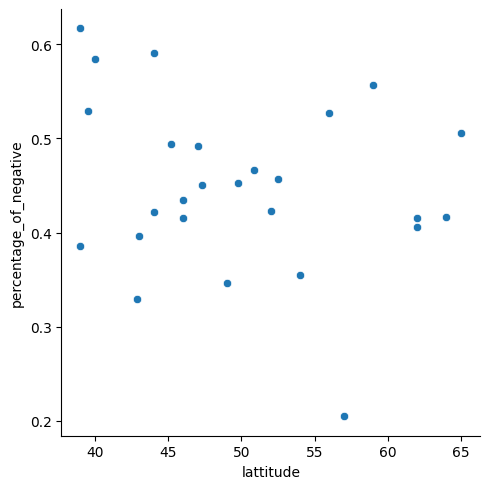

In [5]:
import seaborn as sns

sns.relplot(
    data=gb1,
    x="lattitude",
    y="percentage_of_negative",
    kind="scatter",
)

In [6]:
df.columns

Index(['newdoc id', 'logits_pondered', 'logits_averaged', 'char_length',
       'metadata', 'country', 'Text_ID', 'ID', 'Title', 'Date', 'Body', 'Term',
       'Session', 'Meeting', 'Sitting', 'Agenda', 'Subcorpus', 'Lang',
       'Speaker_role', 'Speaker_MP', 'Speaker_minister', 'Speaker_party',
       'Speaker_party_name', 'Party_status', 'Party_orientation', 'Speaker_ID',
       'Speaker_name', 'Speaker_gender', 'Speaker_birth'],
      dtype='object')

In [7]:
mapping = {
    'Centre': 'Centre',
    'Centre-right': 'Centre-Right',
    'Big tent': 'Centre',
    'Centre-left': 'Centre-Left',
    'Syncretic politics': 'Centre',
    'Centre to centre-left': 'Centre-Left',
    'Right to far-right': 'Right',
    'Centre-right to right': 'Centre-Right',
    'Far-left': 'Left',
    'Centre;Centre-right': 'Centre-Right',
    'Centre;Centre-left': 'Centre-Left',
    'Centre to centre-right': 'Centre-Right',
    'Centre;Syncretic politics': 'Centre',
    'Centre;Centre to centre-left': 'Centre-Left',
    'Centre-right;Left': 'Centre-Right',
    'Centre-right to right;Centre': 'Centre-Right',
    'Centre-right;Centre': 'Centre-Right',
    'Right': 'Right',
    'Centre-left to left': 'Left',
    'Far-right': 'Right',
    'Left': 'Left',
    'Left to far-left': 'Left',
    'Centre to centre-right;Centre': 'Centre-Right',
    'Centre-right;Centre-left': 'Centre-Right',
    'Centre-right;Centre to centre-left': 'Centre-Right',
    'Pirate Party': 'Centre',
    'Centre-left to left;Left': 'Left',
    'Single Issue Politics': 'Centre',
    'Right to far-right;Centre-right': 'Right',
    'Centre-left;Right to far-right': 'Right',
    'Far-right;Centre-right': 'Right',
    'Centre-left Center-left': 'Centre-Left',
    'Left Left': 'Left',
    'Centre-right Center-right': 'Centre-Right',
    'Right to far-right;Right': 'Right',
    'Big tent;;Centre-right': 'Centre-Right'
}

df["Party_category"] = df.Party_orientation.apply(lambda s: mapping.get(s, s))

In [8]:
df.Party_status.unique()

array(['-', 'Coalition', 'Opposition'], dtype=object)

In [9]:
gb1 = df.groupby(["country", "Party_category"]).agg({
    "logits_pondered": "mean"
})
gb2 = df.groupby(["Party_status", "country", "Party_category"]).agg({
    "logits_pondered": "mean"
})
gb2

logits_pondered
Party_status country Party_category                 
-            AT      -                      2.706501
                     Centre                 1.735174
                     Centre-Left            2.244284
                     Centre-Right           3.007877
                     Left                   2.055122
...                                              ...
Opposition   UA      Centre                 2.227478
                     Centre-Left            2.134171
                     Centre-Right           2.447649
                     Left                   2.173879
                     Right                  2.485463

[311 rows x 1 columns]

In [10]:
main = gb1.reset_index().rename(columns={"logits_pondered": "Overall_mean"}
).merge(gb2.loc["Coalition"].reset_index().rename(columns={
    "logits_pondered": "Coalition_mean"
}), how="left", on=["country", "Party_category"]).merge(gb2.loc["Opposition"].reset_index().rename(columns={
    "logits_pondered": "Opposition_mean"
}), how="left", on=["country", "Party_category"])
main

,country,Party_category,Overall_mean,Coalition_mean,Opposition_mean
0,AT,-,2.706501,NaN,NaN
1,AT,Centre,1.734406,NaN,1.728136
2,AT,Centre-Left,2.845592,3.094558,2.830530
3,AT,Centre-Right,3.008407,3.018021,1.900336
4,AT,Left,1.917465,2.664234,1.548604
...,...,...,...,...,...
140,UA,Centre,2.906503,2.786432,2.227478
141,UA,Centre-Left,2.180297,3.131229,2.134171
142,UA,Centre-Right,3.101471,2.782432,2.447649
143,UA,Left,2.745588,2.169930,2.173879


In [25]:
p1 = main.pivot(
    index="country",
    columns= "Party_category",
    values = "Overall_mean"
)
p1 = p1["Left Centre-Left Centre Centre-Right Right".split()]
p1.columns = pd.MultiIndex.from_tuples([("Overall", i) for i in p1.columns])
p2 = main.pivot(
    index="country",
    columns= "Party_category",
    values = "Coalition_mean"
)
p2 = p2["Left Centre-Left Centre Centre-Right Right".split()]
p2.columns = pd.MultiIndex.from_tuples([("Coalition", i) for i in p2.columns])
p3 = main.pivot(
    index="country",
    columns= "Party_category",
    values = "Opposition_mean"
)
p3 = p3["Left Centre-Left Centre Centre-Right Right".split()]
p3.columns = pd.MultiIndex.from_tuples([("Opposition", i) for i in p3.columns])

country_orientation = pd.concat([p1,p2, p3], axis=1)
country_orientation

Overall                                              Coalition  \
             Left Centre-Left    Centre Centre-Right     Right      Left   
country                                                                    
AT       1.917465    2.845592  1.734406     3.008407  2.559515  2.664234   
BA       1.666889    2.466830  2.672092     2.742049  2.888698       NaN   
BE       2.050566    2.052908  1.679343     2.333590  1.840795  2.482484   
BG            NaN    2.248184  2.891203     2.972493  2.528733       NaN   
CZ       2.915468    2.850686       NaN     2.661986  2.486893       NaN   
DK       2.582627    2.800843       NaN     2.719009  2.746238       NaN   
EE            NaN    2.443796       NaN     2.413851  2.141397       NaN   
ES       1.775892    2.600853  1.968554     2.274471  1.266714  2.287610   
FI       1.953698    2.340302  2.690255     2.391942  2.314512  2.367526   
FR       1.787015         NaN  2.465322     2.260592  2.427493       NaN   
GB       1.873893    1.919056  1.674932     2.966977  2.226528       NaN   
GR       2.553136    2.798555  3.117941     2.536669  2.906762  2.688261   
HR       1.736945    2.561230  1.712839     2.829316  1.801464  1.758268   
HU       1.476013    2.121529  1.554577     2.302386  3.089471       NaN   
IS       2.121958    1.799403  1.854836     2.240408       NaN  2.498585   
IT       2.189797    2.600820  2.384304     2.462216  2.460324       NaN   
LV            NaN    2.467450  2.772663     3.059675  3.489795       NaN   
NL       1.975818    2.603715  2.431554     2.338865  1.866744       NaN   
NO       2.107894    2.481506  2.308546     2.488648  2.294312  2.499257   
PL       3.017528         NaN  1.696464     3.063234  2.991375       NaN   
PT       2.071879    2.722122       NaN     2.155529  1.332112  2.133115   
RS       2.302282    2.719436  2.710619     2.868282  1.783793  2.317600   
SE       1.778082    2.585987       NaN     1.999061  1.727071       NaN   
SI       1.564372    2.816585  2.787596     2.419359  2.518166       NaN   
TR       2.022996    2.013328  1.982046     1.794094  2.297579       NaN   
UA       2.745588    2.180297  2.906503     3.101471  2.527946  2.169930   

                                                     Opposition              \
        Centre-Left    Centre Centre-Right     Right       Left Centre-Left   
country                                                                       
AT         3.094558       NaN     3.018021  2.272777   1.548604    2.830530   
BA         3.037673  2.634818     2.979602  2.832586   1.629174    2.201181   
BE         2.290154       NaN     2.463980       NaN   1.929230    1.995932   
BG         2.890958  3.019152     3.043640  2.851172        NaN    2.046592   
CZ         2.910076       NaN     2.906684       NaN   2.879139    2.731083   
DK         2.950394       NaN     2.822146       NaN   2.430268    2.616840   
EE         2.723021       NaN     2.651226  2.564750        NaN         NaN   
ES         2.844985       NaN     2.628481       NaN   1.608225    2.199075   
FI         2.829640  2.720071     2.609359  2.468408   1.783160    1.947977   
FR              NaN  2.501938     2.526457       NaN   1.560373         NaN   
GB         2.576227       NaN     2.780910       NaN        NaN    1.906139   
GR              NaN       NaN          NaN  3.118240   2.201419    2.798555   
HR         2.673235  1.522452     2.906375  1.815782   1.718878    1.910060   
HU              NaN       NaN          NaN  3.123489   1.477448    2.144580   
IS              NaN  2.644223     2.458448       NaN        NaN         NaN   
IT         2.621404  2.569944     2.594509  2.516355   2.308252    2.307917   
LV              NaN  2.791045     3.121356  3.517181        NaN    2.461380   
NL         2.475262  2.467873     2.372353       NaN   1.981960    2.056465   
NO         2.668638  2.618607     2.649218  2.671172        NaN         NaN   
PL              NaN       NaN          NaN  3.032544   3.010879    

In [21]:
country_orientation.reset_index()

country   Overall                                              Coalition  \
                Left Centre-Left    Centre Centre-Right     Right      Left   
0       AT  1.917465    2.845592  1.734406     3.008407  2.559515  2.664234   
1       BA  1.666889    2.466830  2.672092     2.742049  2.888698       NaN   
2       BE  2.050566    2.052908  1.679343     2.333590  1.840795  2.482484   
3       BG       NaN    2.248184  2.891203     2.972493  2.528733       NaN   
4       CZ  2.915468    2.850686       NaN     2.661986  2.486893       NaN   
5       DK  2.582627    2.800843       NaN     2.719009  2.746238       NaN   
6       EE       NaN    2.443796       NaN     2.413851  2.141397       NaN   
7       ES  1.775892    2.600853  1.968554     2.274471  1.266714  2.287610   
8       FI  1.953698    2.340302  2.690255     2.391942  2.314512  2.367526   
9       FR  1.787015         NaN  2.465322     2.260592  2.427493       NaN   
10      GB  1.873893    1.919056  1.674932     2.966977  2.226528       NaN   
11      GR  2.553136    2.798555  3.117941     2.536669  2.906762  2.688261   
12      HR  1.736945    2.561230  1.712839     2.829316  1.801464  1.758268   
13      HU  1.476013    2.121529  1.554577     2.302386  3.089471       NaN   
14      IS  2.121958    1.799403  1.854836     2.240408       NaN  2.498585   
15      IT  2.189797    2.600820  2.384304     2.462216  2.460324       NaN   
16      LV       NaN    2.467450  2.772663     3.059675  3.489795       NaN   
17      NL  1.975818    2.603715  2.431554     2.338865  1.866744       NaN   
18      NO  2.107894    2.481506  2.308546     2.488648  2.294312  2.499257   
19      PL  3.017528         NaN  1.696464     3.063234  2.991375       NaN   
20      PT  2.071879    2.722122       NaN     2.155529  1.332112  2.133115   
21      RS  2.302282    2.719436  2.710619     2.868282  1.783793  2.317600   
22      SE  1.778082    2.585987       NaN     1.999061  1.727071       NaN   
23      SI  1.564372    2.816585  2.787596     2.419359  2.518166       NaN   
24      TR  2.022996    2.013328  1.982046     1.794094  2.297579       NaN   
25      UA  2.745588    2.180297  2.906503     3.101471  2.527946  2.169930   

                                                Opposition              \
   Centre-Left    Centre Centre-Right     Right       Left Centre-Left   
0     3.094558       NaN     3.018021  2.272777   1.548604    2.830530   
1     3.037673  2.634818     2.979602  2.832586   1.629174    2.201181   
2     2.290154       NaN     2.463980       NaN   1.929230    1.995932   
3     2.890958  3.019152     3.043640  2.851172        NaN    2.046592   
4     2.910076       NaN     2.906684       NaN   2.879139    2.731083   
5     2.950394       NaN     2.822146       NaN   2.430268    2.616840   
6     2.723021       NaN     2.651226  2.564750        NaN         NaN   
7     2.844985       NaN     2.628481       NaN   1.608225    2.199075   
8     2.829640  2.720071     2.609359  2.468408   1.783160    1.947977   
9          NaN  2.501938     2.526457       NaN   1.560373         NaN   
10    2.576227       NaN     2.780910       NaN        NaN    1.906139   
11         NaN       NaN          NaN  3.118240   2.201419    2.798555   
12    2.673235  1.522452     2.906375  1.815782   1.718878    1.910060   
13         NaN       NaN          NaN  3.123489   1.477448    2.144580   
14         NaN  2.644223     2.458448       NaN        NaN         NaN   
15    2.621404  2.569944     2.594509  2.516355   2.308252    2.307917   
16         NaN  2.791045     3.121356  3.517181        NaN    2.461380   
17    2.475262  2.467873     2.372353       NaN   1.981960    2.056465   
18    2.668638  2.618607     2.649218  2.671172        NaN         NaN   
19         NaN       NaN          NaN  3.032544   3.010879         NaN   
20    2.786347       NaN     2.643285       NaN   1.624542    2.100853   
21    2.768137  2.724801     2.875268  2.326143   2.037155    2.427436   
22    2.596620

/home/peterr/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


,country,ruling,Party_category,value
0,AT,Overall,Left,1.917465
1,BA,Overall,Left,1.666889
2,BE,Overall,Left,2.050566
3,BG,Overall,Left,NaN
4,CZ,Overall,Left,2.915468
...,...,...,...,...
385,RS,Opposition,Right,1.545786
386,SE,Opposition,Right,NaN
387,SI,Opposition,Right,2.285147
388,TR,Opposition,Right,1.911244


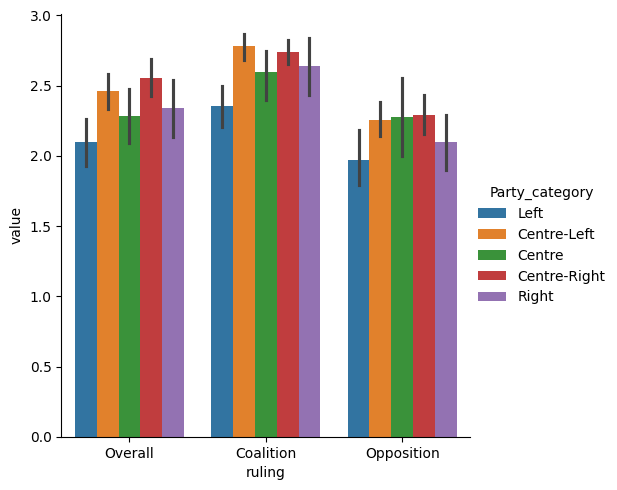

In [38]:
p1 = main.pivot(
    index="country",
    columns= "Party_category",
    values = "Overall_mean"
)
p1 = p1["Left Centre-Left Centre Centre-Right Right".split()]
p1["ruling"] = "Overall"
p2 = main.pivot(
    index="country",
    columns= "Party_category",
    values = "Coalition_mean"
)
p2 = p2["Left Centre-Left Centre Centre-Right Right".split()]
p2["ruling"] = "Coalition"
p3 = main.pivot(
    index="country",
    columns= "Party_category",
    values = "Opposition_mean"
)
p3 = p3["Left Centre-Left Centre Centre-Right Right".split()]
p3["ruling"] = "Opposition"

country_orientation = pd.concat([p1,p2, p3], axis=0).reset_index().melt(
    id_vars=["country", "ruling"]
)

sns.catplot(
    country_orientation,
    x="ruling",
    hue="Party_category",
    y="value",
    kind="bar"
)
country_orientation

In [28]:
country_orientation.

,country,kind,Party_category,value
0,AT,Overall,Left,1.917465
1,BA,Overall,Left,1.666889
2,BE,Overall,Left,2.050566
3,BG,Overall,Left,NaN
4,CZ,Overall,Left,2.915468
...,...,...,...,...
385,RS,Opposition,Right,1.545786
386,SE,Opposition,Right,NaN
387,SI,Opposition,Right,2.285147
388,TR,Opposition,Right,1.911244
